In [1]:
#%pip install scipy==1.11.4

In [3]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from functions.missclassification_rate import missclassification_rate

# Data and model imports

In [4]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

# Evaluation

## Logistic Regression

In [4]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

### Predictions

In [5]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These u

In [ ]:
importances = list(u_lr.best_estimator_.named_steps['model'].feature_importances_)
f_names = list(u_lr.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

In [ ]:
importances = list(o_lr.best_estimator_.named_steps['model'].feature_importances_)
f_names = list(o_lr.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [6]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7605 p-value: 0.000e+00


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


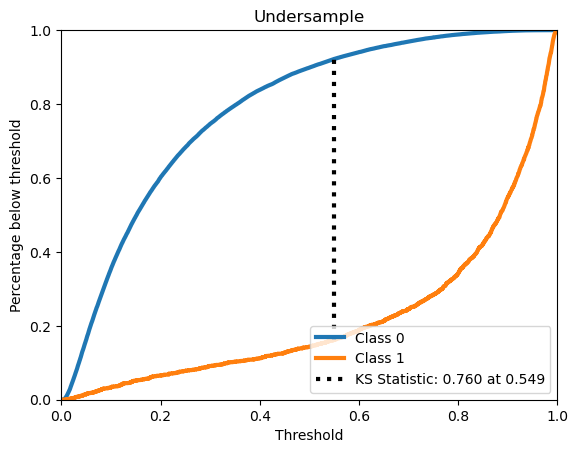

In [7]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [8]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7615 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


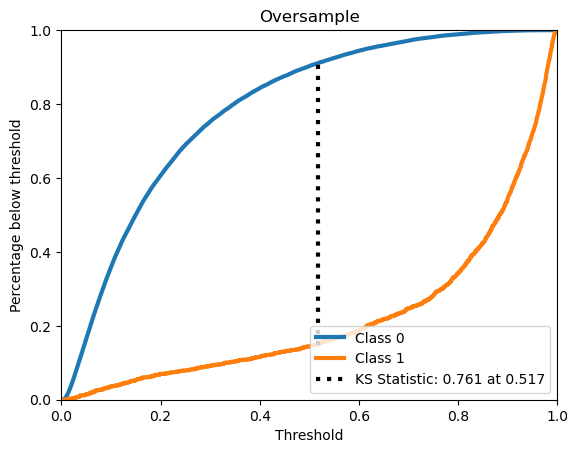

In [9]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [10]:
lr_under_cut_off = 0.549
lr_over_cut_off = 0.517
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

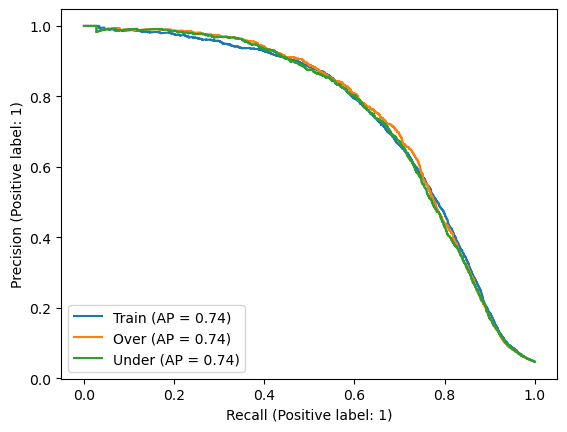

In [11]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

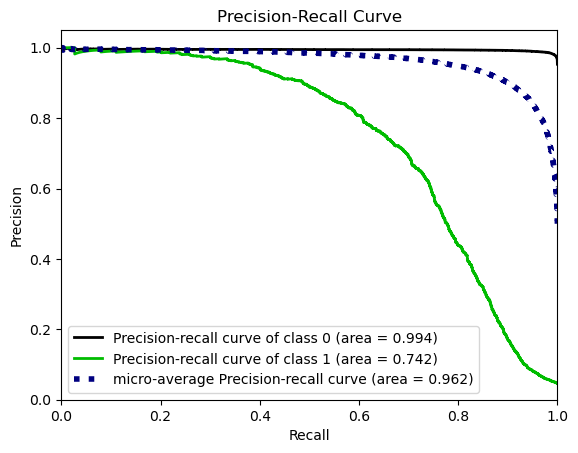

In [12]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba)

### Confussion matrix

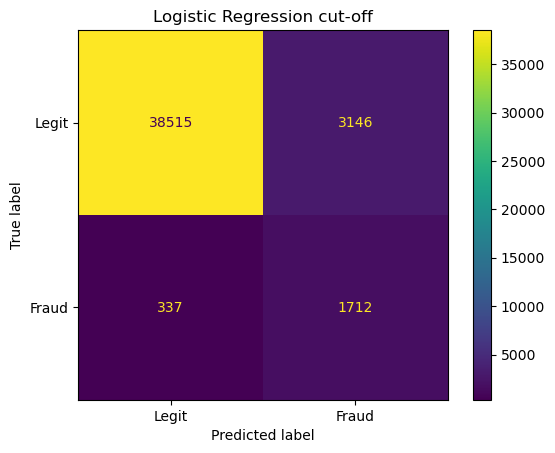

In [13]:
lr_cm = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = ['Legit', 'Fraud'])
lr_cm_display.plot()
plt.title('Logistic Regression cut-off')
plt.show()

False Negative: 337

### Cumulative Gain

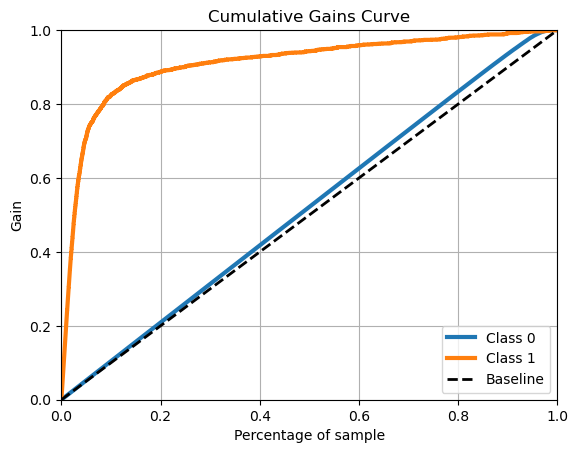

In [14]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

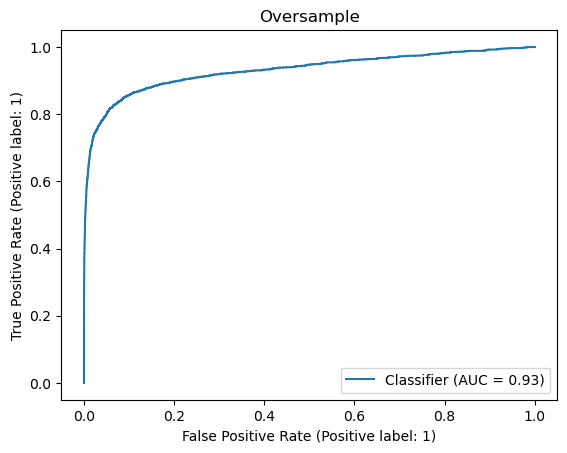

In [15]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [16]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.9018119778797505 Test: 0.9203157172271791


In [17]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     41661
           1       0.35      0.84      0.50      2049

    accuracy                           0.92     43710
   macro avg       0.67      0.88      0.73     43710
weighted avg       0.96      0.92      0.94     43710



In [18]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.09938229238160604


# Random Forest

In [5]:
with open('models/under_rf.pkl', 'rb') as f:
    u_rf = pickle.load(f)
f.close()

with open('models/over_rf.pkl', 'rb') as f:
    o_rf = pickle.load(f)
f.close()

### Predictions

In [6]:
rf_under_y_pred = u_rf.predict(X_test)
rf_over_y_pred = o_rf.predict(X_test)

rf_under_y_pred_proba = u_rf.predict_proba(X_test)
rf_over_y_pred_proba =o_rf.predict_proba(X_test)

under_train_pred = u_rf.predict(X_train)
over_train_pred = o_rf.predict(X_train)
under_train_pred_proba = u_rf.predict_proba(X_train)
over_train_pred_proba = o_rf.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categ

In [8]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,0.366337
154,num__acc_age,0.128683
150,num__transaction_amt,0.103750
9,cat__cvv_H,0.026683
152,num__historic_velocity,0.025028
...,...,...
82,cat__transaction_env_K,0.000000
83,cat__transaction_env_L,0.000000
42,cat__signature_image_T,0.000000
84,cat__transaction_env_M,0.000000


In [9]:
importances = list(o_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(o_rf.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
157,num__transaction_adj_amt,0.457881
160,num__acc_age,0.116830
156,num__transaction_amt,0.076965
158,num__historic_velocity,0.026616
9,cat__cvv_H,0.016415
...,...,...
65,cat__transaction_type_M,0.000000
64,cat__transaction_type_L,0.000000
46,cat__signature_image_T,0.000000
63,cat__transaction_type_K,0.000000


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [10]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7594 p-value: 0.000e+00


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


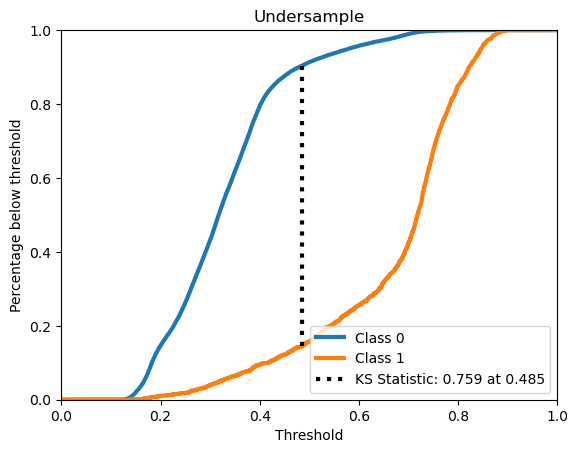

In [11]:
skplt.metrics.plot_ks_statistic(y_test, rf_under_y_pred_proba, title='Undersample')
plt.show()

In [12]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7936 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


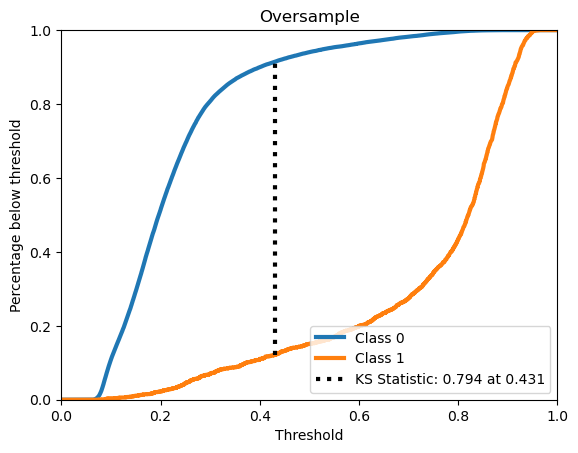

In [14]:
skplt.metrics.plot_ks_statistic(y_test, rf_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [18]:
rf_under_cut_off = 0.485
rf_over_cut_off = 0.431
rf_over_y_pred_proba_class = np.where(rf_over_y_pred_proba[:, 1] > rf_under_cut_off, 1, 0)
rf_under_y_pred_proba_class = np.where(rf_under_y_pred_proba[:, 1] > rf_over_cut_off, 1, 0)

### Precision-Recall Curve

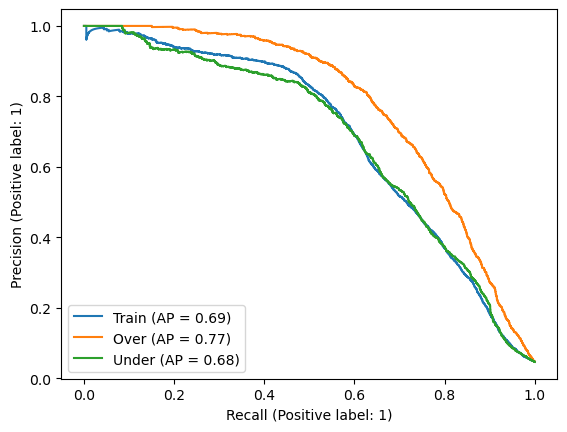

In [15]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

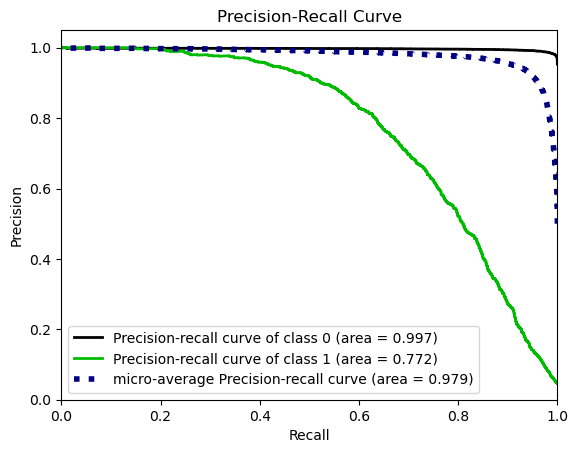

In [16]:
skplt.metrics.plot_precision_recall(y_test, rf_over_y_pred_proba)

### Confussion matrix

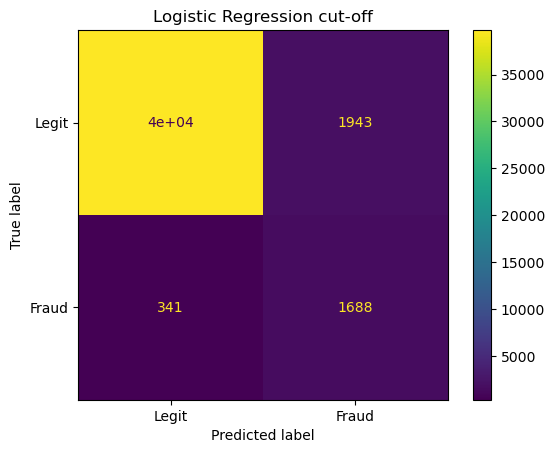

In [19]:
rf_cm = confusion_matrix(y_test, rf_over_y_pred_proba_class)
rf_cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = ['Legit', 'Fraud'])
rf_cm_display.plot()
plt.title('Logistic Regression cut-off')
plt.show()

### Cumulative Gain

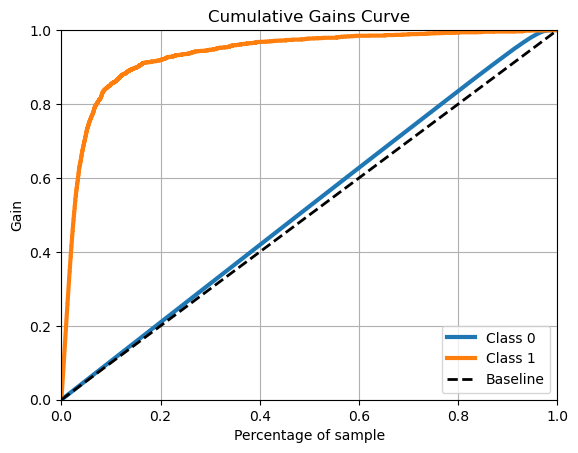

In [20]:
skplt.metrics.plot_cumulative_gain(y_test, rf_over_y_pred_proba)
plt.show()

### ROC

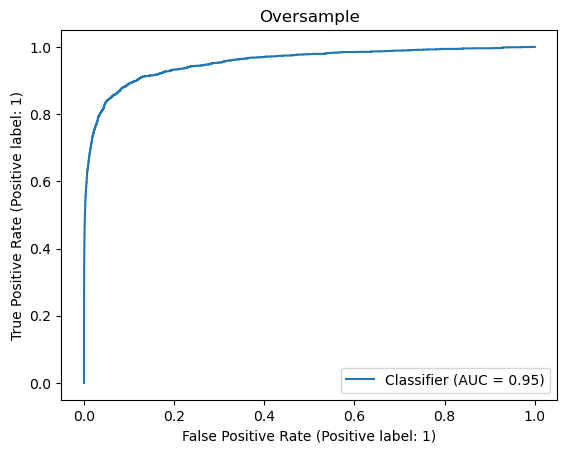

In [21]:
RocCurveDisplay.from_predictions(
    y_test, rf_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [22]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, rf_over_y_pred_proba_class)}')

Accuracy Train: 0.9345020982860729 Test: 0.9477465110958591


In [23]:
print(classification_report(y_test, rf_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     41681
           1       0.46      0.83      0.60      2029

    accuracy                           0.95     43710
   macro avg       0.73      0.89      0.78     43710
weighted avg       0.97      0.95      0.95     43710



In [24]:
print(f'The missclasification rate is: {missclassification_rate(y_test, rf_over_y_pred)}')

The missclasification rate is: 0.06387554335392359


# XGBoosting

In [26]:
with open('models/under_xgb.pkl', 'rb') as f:
    u_xgb = pickle.load(f)
f.close()

with open('models/over_xgb.pkl', 'rb') as f:
    o_xgb = pickle.load(f)
f.close()

### Predictions

In [27]:
xgb_under_y_pred = u_xgb.predict(X_test)
xgb_over_y_pred = o_xgb.predict(X_test)

xgb_under_y_pred_proba = u_xgb.predict_proba(X_test)
xgb_over_y_pred_proba =o_xgb.predict_proba(X_test)

under_train_pred = u_xgb.predict(X_train)
over_train_pred = o_xgb.predict(X_train)
under_train_pred_proba = u_xgb.predict_proba(X_train)
over_train_pred_proba = o_xgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

In [28]:
importances = list(u_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(u_xgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
153,num__transaction_adj_amt,0.082908
156,num__acc_age,0.035129
74,cat__transaction_type_X,0.034186
9,cat__cvv_H,0.032150
19,cat__cvv_S,0.029268
...,...,...
122,cat__tranaction_initiate_V,0.000000
124,cat__tranaction_initiate_X,0.000000
95,cat__transaction_env_UN,0.000000
49,cat__signature_image_Y,0.000000


In [29]:
importances = list(o_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(o_xgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,0.075338
22,cat__cvv_V,0.037092
154,num__acc_age,0.035744
14,cat__cvv_N,0.033122
9,cat__cvv_H,0.028656
...,...,...
25,cat__cvv_Y,0.000000
30,cat__signature_image_E,0.000000
36,cat__signature_image_M,0.000000
48,cat__signature_image_Y,0.000000


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [30]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.8111 p-value: 0.000e+00


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


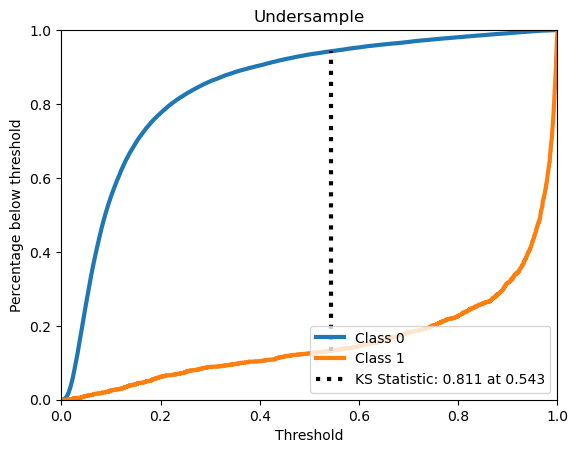

In [31]:
skplt.metrics.plot_ks_statistic(y_test, xgb_under_y_pred_proba, title='Undersample')
plt.show()

In [32]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.8201 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


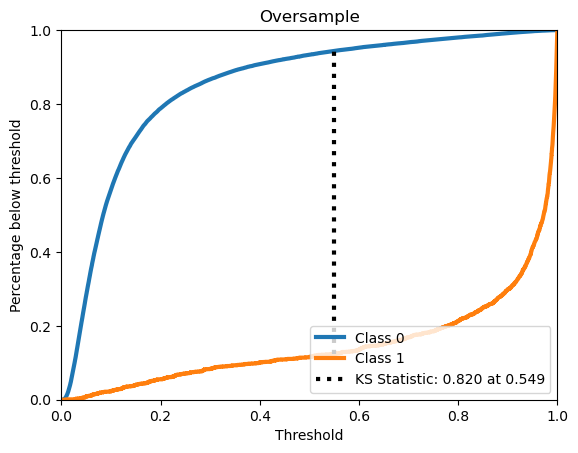

In [33]:
skplt.metrics.plot_ks_statistic(y_test, xgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [34]:
xgb_under_cut_off = 0.543
xgb_over_cut_off = 0.549
xgb_over_y_pred_proba_class = np.where(xgb_over_y_pred_proba[:, 1] > xgb_under_cut_off, 1, 0)
xgb_under_y_pred_proba_class = np.where(xgb_under_y_pred_proba[:, 1] > xgb_over_cut_off, 1, 0)

### Precision-Recall Curve

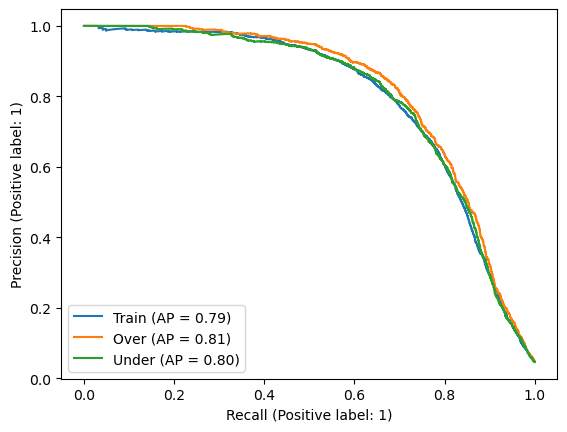

In [35]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

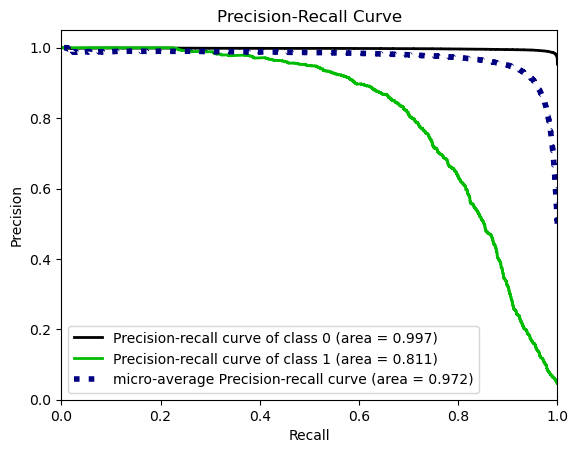

In [36]:
skplt.metrics.plot_precision_recall(y_test, xgb_over_y_pred_proba)

### Confussion matrix

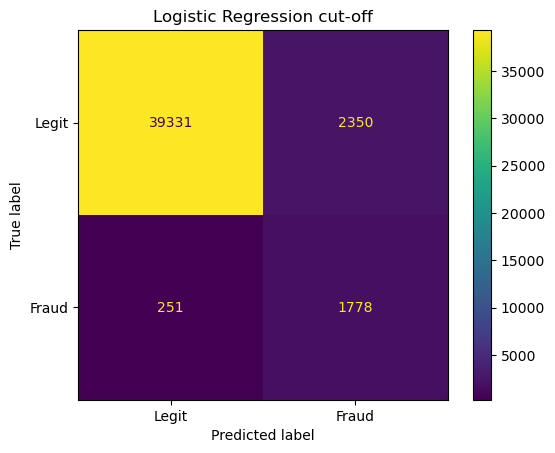

In [37]:
xgb_cm = confusion_matrix(y_test, xgb_over_y_pred_proba_class)
xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = ['Legit', 'Fraud'])
xgb_cm_display.plot()
plt.title('Logistic Regression cut-off')
plt.show()

### Cumulative Gain

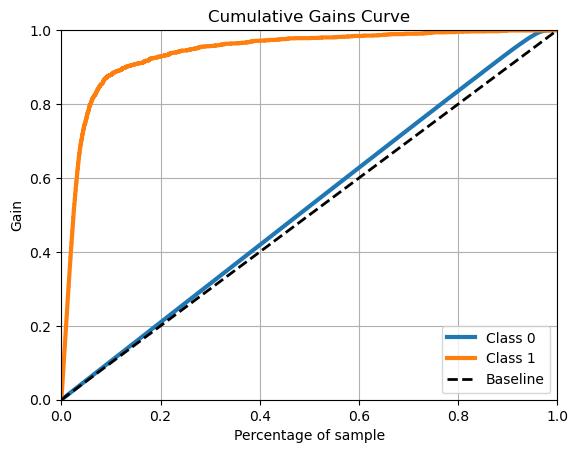

In [39]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_over_y_pred_proba)
plt.show()

### ROC

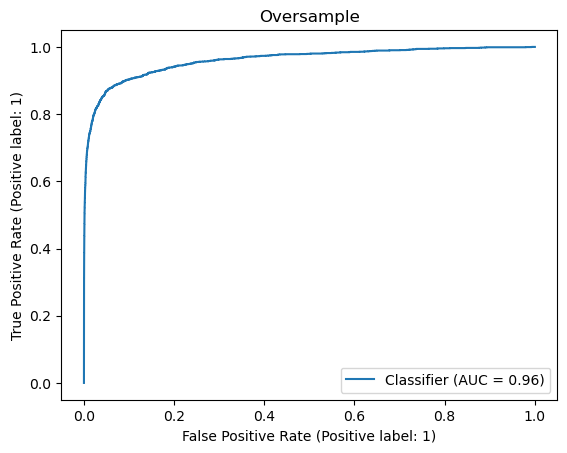

In [40]:
RocCurveDisplay.from_predictions(
    y_test, xgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [41]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, xgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9287563242734439 Test: 0.9404941660947151


In [42]:
print(classification_report(y_test, xgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     41681
           1       0.43      0.88      0.58      2029

    accuracy                           0.94     43710
   macro avg       0.71      0.91      0.77     43710
weighted avg       0.97      0.94      0.95     43710



In [43]:
print(f'The missclasification rate is: {missclassification_rate(y_test, xgb_over_y_pred)}')

The missclasification rate is: 0.06902310684053992


# LGBoosting

In [44]:
with open('models/under_lgb.pkl', 'rb') as f:
    u_lgb = pickle.load(f)
f.close()

with open('models/over_lgb.pkl', 'rb') as f:
    o_lgb = pickle.load(f)
f.close()

### Predictions

In [45]:
lgb_under_y_pred = u_lgb.predict(X_test)
lgb_over_y_pred = o_lgb.predict(X_test)

lgb_under_y_pred_proba = u_lgb.predict_proba(X_test)
lgb_over_y_pred_proba =o_lgb.predict_proba(X_test)

under_train_pred = u_lgb.predict(X_train)
over_train_pred = o_lgb.predict(X_train)
under_train_pred_proba = u_lgb.predict_proba(X_train)
over_train_pred_proba = o_lgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

In [46]:
importances = list(u_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(u_lgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
152,num__transaction_adj_amt,57
155,num__acc_age,46
151,num__transaction_amt,30
153,num__historic_velocity,27
2,cat__currency_usd,21
...,...,...
60,cat__transaction_type_K,0
59,cat__transaction_type_J,0
54,cat__transaction_type_E,0
51,cat__transaction_type_B,0


In [47]:
importances = list(o_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(o_lgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,97
154,num__acc_age,54
152,num__historic_velocity,32
150,num__transaction_amt,30
2,cat__currency_usd,25
...,...,...
55,cat__transaction_type_G,0
57,cat__transaction_type_I,0
58,cat__transaction_type_J,0
59,cat__transaction_type_K,0


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [48]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.7386 p-value: 0.000e+00


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


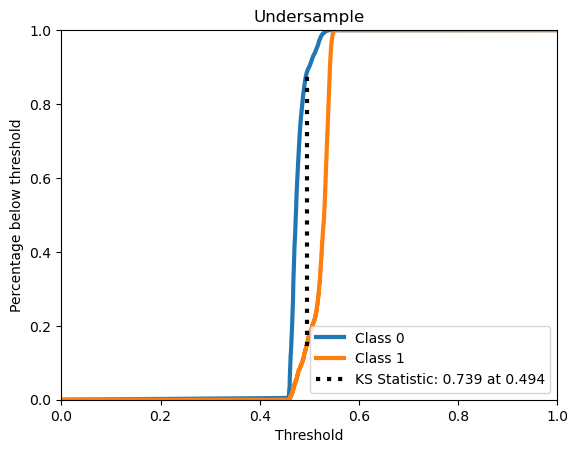

In [49]:
skplt.metrics.plot_ks_statistic(y_test, lgb_under_y_pred_proba, title='Undersample')
plt.show()

In [50]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")

0.6957 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


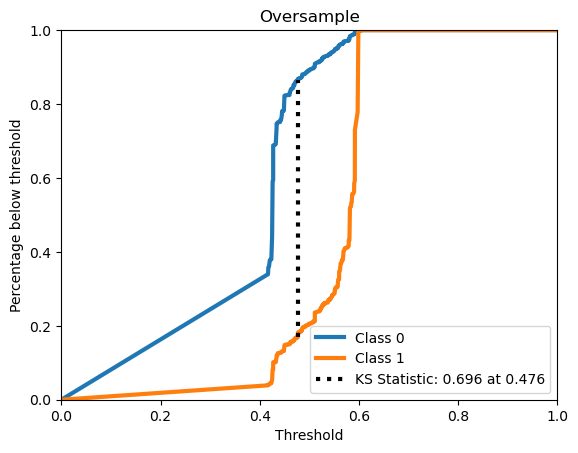

In [51]:
skplt.metrics.plot_ks_statistic(y_test, lgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [52]:
lgb_under_cut_off = 0.494
lgb_over_cut_off = 0.476
lgb_over_y_pred_proba_class = np.where(lgb_over_y_pred_proba[:, 1] > lgb_under_cut_off, 1, 0)
lgb_under_y_pred_proba_class = np.where(lgb_under_y_pred_proba[:, 1] > lgb_over_cut_off, 1, 0)

### Precision-Recall Curve

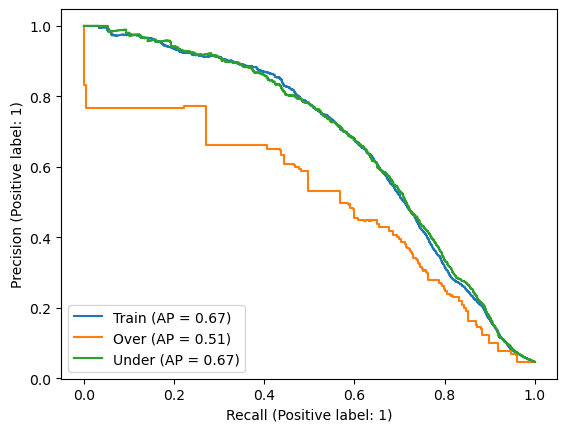

In [53]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

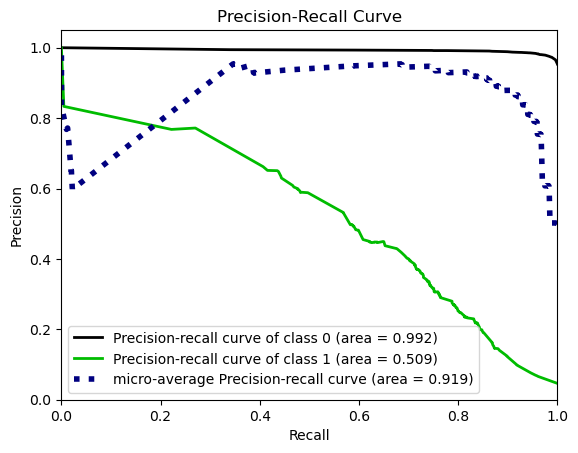

In [54]:
skplt.metrics.plot_precision_recall(y_test, lgb_over_y_pred_proba)

### Confussion matrix

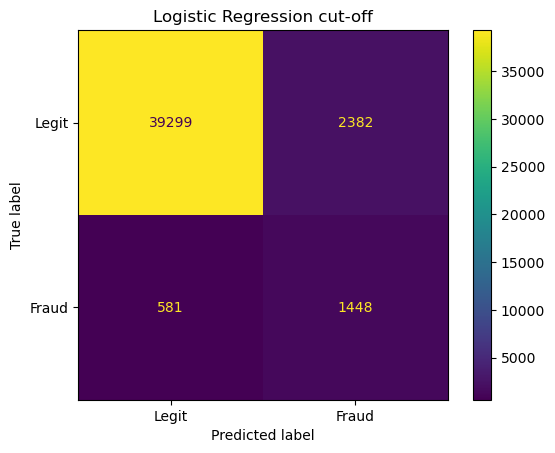

In [55]:
lgb_cm = confusion_matrix(y_test, lgb_over_y_pred_proba_class)
lgb_cm_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm, display_labels = ['Legit', 'Fraud'])
lgb_cm_display.plot()
plt.title('Logistic Regression cut-off')
plt.show()

### Cumulative Gain

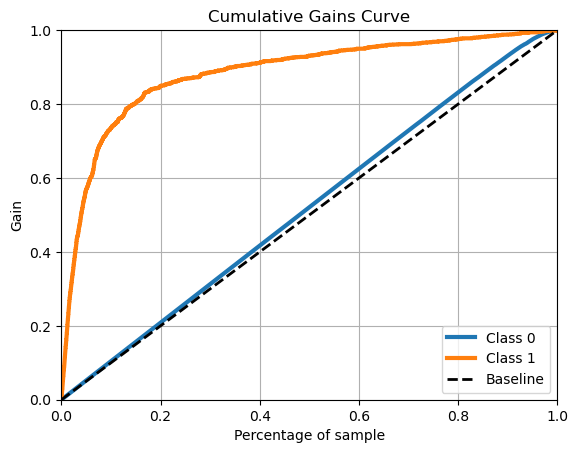

In [56]:
skplt.metrics.plot_cumulative_gain(y_test, lgb_over_y_pred_proba)
plt.show()

### ROC

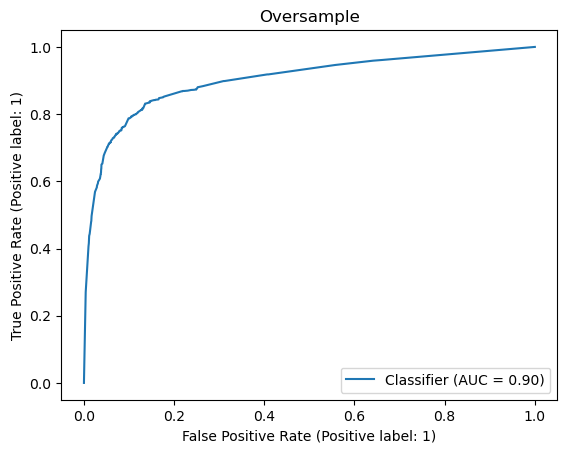

In [57]:
RocCurveDisplay.from_predictions(
    y_test, lgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [58]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lgb_over_y_pred_proba_class)}')

Accuracy Train: 0.8845746558418638 Test: 0.932212308396248


In [59]:
print(classification_report(y_test, lgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41681
           1       0.38      0.71      0.49      2029

    accuracy                           0.93     43710
   macro avg       0.68      0.83      0.73     43710
weighted avg       0.96      0.93      0.94     43710



In [60]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lgb_over_y_pred)}')

The missclasification rate is: 0.1123541523678792
